In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_poisson_deviance, mean_absolute_error
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP
from scipy.stats import poisson
import requests

In [2]:
seasons = [
    '1011', '1112', '1213', '1314',
    '1415', '1516', '1617', '1718', '1819', '1920', '2021',
    '2122', '2223', '2324'
]

base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"

all_seasons = []

for season in seasons:
    try:
        url = base_url.format(season)
        df = pd.read_csv(url)
        df['Season'] = season
        all_seasons.append(df)

    except Exception as e:
        print(f"Failed {season}: {e}")

premData = pd.concat(all_seasons, ignore_index=True)

premData.to_csv('premAllMatches.csv', index=False)

print(f"\nTotal matches: {len(premData)}")


columns_to_keep = [
    'Date', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',
    'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HY','AY','HR','AR',
    'B365H', 'B365D', 'B365A', 'Season'
]
cleanData = premData[columns_to_keep]



Total matches: 5321


In [3]:
teamsCheck = (set(cleanData["HomeTeam"]))
print(teamsCheck)

{'West Ham', 'Aston Villa', 'Everton', 'Watford', 'Blackpool', 'Leeds', 'Norwich', 'Man City', 'Huddersfield', 'Middlesbrough', 'Birmingham', 'Liverpool', 'Southampton', 'QPR', 'Hull', 'Tottenham', 'Newcastle', 'Burnley', "Nott'm Forest", 'Leicester', 'Wolves', 'Sheffield United', 'Stoke', 'Brentford', 'Cardiff', 'Bournemouth', 'Bolton', 'Reading', 'Crystal Palace', 'Arsenal', 'Chelsea', 'Blackburn', 'Sunderland', 'Wigan', 'Brighton', 'Luton', 'Swansea', nan, 'Fulham', 'West Brom', 'Man United'}


In [4]:
#Enter games to predict here:
homeTeamsToPredict = []
awayTeamsToPredict = []
datesToPredict = []

numGames = input("How Many Games would you like to predict?: ")
gameInfo = [{} for _ in range(0,int(numGames))]
for i in range(int(numGames)):
  currHome = input("Enter The Name Of The Home Team: ")
  if currHome not in teamsCheck:
    print("Team not allowed")
    break
  homeTeamsToPredict.append(currHome)
  currAway = input("Enter The Name Of The Away Team: ")
  if currAway not in teamsCheck:
    print("Team not allowed")
    break
  awayTeamsToPredict.append(currAway)
  month = input("Enter Month of Game: ")
  if len(month)==1:
    month="0"+month
  date = input("Enter Date of Game: ")
  if len(date)==1:
    date="0"+date
  year = input("Enter Year of Game: ")
  currDate = year+"-"+month+"-"+date
  datesToPredict.append(currDate)
print(homeTeamsToPredict,awayTeamsToPredict,datesToPredict)


How Many Games would you like to predict?: 1
Enter The Name Of The Home Team: Brentford
Enter The Name Of The Away Team: Arsenal
Enter Month of Game: 01
Enter Date of Game: 10
Enter Year of Game: 2027
['Brentford'] ['Arsenal'] ['2027-01-10']


In [5]:
def build_team_level_df(
    matches: pd.DataFrame,
    date_col: str = "Date",
    rolling_windows=(5, 10),
    ewm_halflife_matches=10,
) -> pd.DataFrame:

    df = cleanData.copy()


    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
    df = df.sort_values([date_col, "HomeTeam", "AwayTeam"]).reset_index(drop=True)


    home = pd.DataFrame({
        "Date": df[date_col],
        "Season": df.get("Season", np.nan),
        "team": df["HomeTeam"],
        "opponent": df["AwayTeam"],
        "is_home": 1,
        "goals_for": df["FTHG"],
        "goals_against": df["FTAG"],
        "shots_for": df.get("HS", np.nan),
        "shots_against": df.get("AS", np.nan),
        "sot_for": df.get("HST", np.nan),
        "sot_against": df.get("AST", np.nan),
        "corners_for": df.get("HC", np.nan),
        "corners_against": df.get("AC", np.nan),
        "yellows_for": df.get("HY", np.nan),
        "yellows_against": df.get("AY", np.nan),
        "reds_for": df.get("HR", np.nan),
        "reds_against": df.get("AR", np.nan),
        "FTR": df["FTR"],
    })


    away = pd.DataFrame({
        "Date": df[date_col],
        "Season": df.get("Season", np.nan),
        "team": df["AwayTeam"],
        "opponent": df["HomeTeam"],
        "is_home": 0,
        "goals_for": df["FTAG"],
        "goals_against": df["FTHG"],
        "shots_for": df.get("AS", np.nan),
        "shots_against": df.get("HS", np.nan),
        "sot_for": df.get("AST", np.nan),
        "sot_against": df.get("HST", np.nan),
        "corners_for": df.get("AC", np.nan),
        "corners_against": df.get("HC", np.nan),
        "yellows_for": df.get("AY", np.nan),
        "yellows_against": df.get("HY", np.nan),
        "reds_for": df.get("AR", np.nan),
        "reds_against": df.get("HR", np.nan),
        "FTR": df["FTR"],
    })

    team_df = pd.concat([home, away], ignore_index=True)
    team_df = team_df.sort_values(["Date", "team", "is_home"]).reset_index(drop=True)


    team_df["points"] = np.where(
        team_df["FTR"].eq("D"), 1,
        np.where(
            (team_df["is_home"].eq(1) & team_df["FTR"].eq("H")) |
            (team_df["is_home"].eq(0) & team_df["FTR"].eq("A")),
            3,
            0
        )
    )


    grp_team = team_df.groupby("team", sort=False)

    for w in rolling_windows:
        team_df[f"gf_roll{w}"] = grp_team["goals_for"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )
        team_df[f"ga_roll{w}"] = grp_team["goals_against"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )
        team_df[f"pts_roll{w}"] = grp_team["points"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )
        team_df[f"sot_for_roll{w}"] = grp_team["sot_for"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )
        team_df[f"sot_against_roll{w}"] = grp_team["sot_against"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )

    team_df["gf_ewm"] = grp_team["goals_for"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )
    team_df["ga_ewm"] = grp_team["goals_against"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )
    team_df["pts_ewm"] = grp_team["points"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )
    team_df["sot_for_ewm"] = grp_team["sot_for"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )
    team_df["sot_against_ewm"] = grp_team["sot_against"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )


    grp_team_venue = team_df.groupby(["team", "is_home"], sort=False)

    team_df["gf_ewm_venue"] = grp_team_venue["goals_for"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )
    team_df["ga_ewm_venue"] = grp_team_venue["goals_against"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )
    team_df["pts_ewm_venue"] = grp_team_venue["points"].transform(
        lambda s: s.shift(1).ewm(halflife=ewm_halflife_matches, adjust=False).mean()
    )

    num_cols = [c for c in team_df.columns if c not in ["Date", "Season", "team", "opponent", "FTR"]]
    team_df[num_cols] = team_df[num_cols].apply(pd.to_numeric, errors="coerce")

    return team_df
team_df = build_team_level_df(cleanData)
print(team_df.shape)

/tmp/ipython-input-1446666480.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")


(10642, 37)


In [6]:


def add_attack_defense_strength(team_df, halflife_matches=10, roll_window=10):

    df = team_df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["team", "Date"]).reset_index(drop=True)

    g = df.groupby("team", sort=False)

    df["attack_strength_ewm"] = g["goals_for"].transform(
        lambda s: s.shift(1).ewm(halflife=halflife_matches, adjust=False).mean()
    )

    df["defense_weakness_ewm"] = g["goals_against"].transform(
        lambda s: s.shift(1).ewm(halflife=halflife_matches, adjust=False).mean()
    )

    df["defense_strength_ewm"] = -df["defense_weakness_ewm"]

    df["attack_strength_roll"] = g["goals_for"].transform(
        lambda s: s.shift(1).rolling(roll_window, min_periods=1).mean()
    )
    df["defense_weakness_roll"] = g["goals_against"].transform(
        lambda s: s.shift(1).rolling(roll_window, min_periods=1).mean()
    )
    df["defense_strength_roll"] = -df["defense_weakness_roll"]

    return df

team_df = add_attack_defense_strength(
    team_df,
    halflife_matches=10,
    roll_window=10
)


def add_stat_strengths(team_df, halflife_matches=10, stats=("corners", "yellows", "reds")):
    df = team_df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["team", "Date"]).reset_index(drop=True)

    g = df.groupby("team", sort=False)

    for stat in stats:
        for_col = f"{stat}_for"
        against_col = f"{stat}_against"

        df[f"{stat}_for_ewm"] = g[for_col].transform(
            lambda s: s.shift(1).ewm(halflife=halflife_matches, adjust=False).mean()
        )
        df[f"{stat}_against_ewm"] = g[against_col].transform(
            lambda s: s.shift(1).ewm(halflife=halflife_matches, adjust=False).mean()
        )

    return df

team_df = add_stat_strengths(
    team_df,
    halflife_matches=10,
    stats=("corners", "yellows", "reds", "shots", "sot")
)



In [7]:

def build_match_level_features(team_df_strength):

    df = team_df_strength.copy()
    df["Date"] = pd.to_datetime(df["Date"])

    home_rows = df[df["is_home"] == 1].copy()
    away_rows = df[df["is_home"] == 0].copy()


    merged = home_rows.merge(
        away_rows,
        left_on=["Date", "team", "opponent"],
        right_on=["Date", "opponent", "team"],
        suffixes=("_homeTeam", "_awayTeam"),
        how="inner"
    )

    merged["FTHG"] = merged["goals_for_homeTeam"]
    merged["FTAG"] = merged["goals_for_awayTeam"]

    merged["home_attack"] = merged["attack_strength_ewm_homeTeam"]
    merged["away_attack"] = merged["attack_strength_ewm_awayTeam"]

    merged["home_vs_away_def"] = merged["home_attack"] - merged["defense_weakness_ewm_awayTeam"]
    merged["away_vs_home_def"] = merged["away_attack"] - merged["defense_weakness_ewm_homeTeam"]

    merged["away_def_weak"] = merged["defense_weakness_ewm_awayTeam"]
    merged["home_def_weak"] = merged["defense_weakness_ewm_homeTeam"]

    merged["home_adv"] = 1

    home_goal_df = merged[[
        "Date",
        "FTHG",
        "home_adv",
        "home_attack",
        "away_def_weak",
        "home_vs_away_def"
    ]].dropna()

    away_goal_df = merged[[
        "Date",
        "FTAG",
        "away_attack",
        "home_def_weak",
        "away_vs_home_def"
    ]].dropna()

    return home_goal_df, away_goal_df

home_goal_df, away_goal_df = build_match_level_features(team_df)

def build_match_level_df_for_stat(team_df_strength, stat: str):
    df = team_df_strength.copy()
    df["Date"] = pd.to_datetime(df["Date"])

    home_rows = df[df["is_home"] == 1].copy()
    away_rows = df[df["is_home"] == 0].copy()

    merged = home_rows.merge(
        away_rows,
        left_on=["Date", "team", "opponent"],
        right_on=["Date", "opponent", "team"],
        suffixes=("_homeTeam", "_awayTeam"),
        how="inner"
    )

    target_home = f"{stat}_home"
    target_away = f"{stat}_away"
    merged[target_home] = merged[f"{stat}_for_homeTeam"]
    merged[target_away] = merged[f"{stat}_for_awayTeam"]

    merged[f"{stat}_home_for"] = merged[f"{stat}_for_ewm_homeTeam"]
    merged[f"{stat}_away_for"] = merged[f"{stat}_for_ewm_awayTeam"]

    merged[f"{stat}_away_concede"] = merged[f"{stat}_against_ewm_awayTeam"]
    merged[f"{stat}_home_concede"] = merged[f"{stat}_against_ewm_homeTeam"]

    merged[f"{stat}_home_vs_away"] = merged[f"{stat}_home_for"] - merged[f"{stat}_away_concede"]
    merged[f"{stat}_away_vs_home"] = merged[f"{stat}_away_for"] - merged[f"{stat}_home_concede"]

    home_df = merged[[
        "Date",
        target_home,
        f"{stat}_home_for",
        f"{stat}_away_concede",
        f"{stat}_home_vs_away",
    ]].dropna()

    home_df["home_adv"] = 1

    away_df = merged[[
        "Date",
        target_away,
        f"{stat}_away_for",
        f"{stat}_home_concede",
        f"{stat}_away_vs_home",
    ]].dropna()

    home_features = ["home_adv", f"{stat}_home_for", f"{stat}_away_concede", f"{stat}_home_vs_away"]
    away_features = [f"{stat}_away_for", f"{stat}_home_concede", f"{stat}_away_vs_home"]

    return home_df, away_df, home_features, away_features

home_corners_df, away_corners_df, hc_feats, ac_feats = build_match_level_df_for_stat(team_df, "corners")

home_yellows_df, away_yellows_df, hy_feats, ay_feats = build_match_level_df_for_stat(team_df, "yellows")

home_reds_df, away_reds_df, hr_feats, ar_feats = build_match_level_df_for_stat(team_df, "reds")

home_shots_df, away_shots_df, hs_feats, as_feats = build_match_level_df_for_stat(team_df, "shots")

home_sot_df, away_sot_df, hsot_feats, asot_feats = build_match_level_df_for_stat(team_df, "sot")


In [8]:
def add_time_decay_weights(df, date_col="Date", half_life_years=1.5):

    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    max_date = d[date_col].max()
    age_years = (max_date - d[date_col]).dt.days / 365.25
    d["sample_weight"] = 0.5 ** (age_years / half_life_years)
    return d

def train_poisson_models(
    team_df: pd.DataFrame,
    feature_cols,
    date_col="Date",
    half_life_years=1.5,
    alpha=0.001,
    train_end_date=None,
    valid_start_date=None
):

    df = team_df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    df = df.dropna(subset=feature_cols + ["goals_for"])

    df = add_time_decay_weights(df, date_col=date_col, half_life_years=half_life_years)


    if train_end_date is not None and valid_start_date is not None:
        train_end_date = pd.to_datetime(train_end_date)
        valid_start_date = pd.to_datetime(valid_start_date)

        train_df = df[df[date_col] <= train_end_date]
        valid_df = df[df[date_col] >= valid_start_date]
    else:
        train_df = df
        valid_df = None

    def fit_one(side_value):
        tr = train_df[train_df["is_home"] == side_value].copy()
        X_tr = tr[feature_cols].to_numpy()
        y_tr = tr["goals_for"].to_numpy()
        w_tr = tr["sample_weight"].to_numpy()

        model = PoissonRegressor(alpha=alpha, max_iter=2000)
        model.fit(X_tr, y_tr, sample_weight=w_tr)

        metrics = {}
        if valid_df is not None and len(valid_df) > 0:
            va = valid_df[valid_df["is_home"] == side_value].copy()
            va = va.dropna(subset=feature_cols + ["goals_for"])
            if len(va) > 0:
                X_va = va[feature_cols].to_numpy()
                y_va = va["goals_for"].to_numpy()
                pred = model.predict(X_va)
                pred = np.clip(pred, 1e-6, None)

                metrics = {
                    "poisson_deviance": mean_poisson_deviance(y_va, pred),
                    "mae_goals": mean_absolute_error(y_va, pred),
                    "n_valid": len(va)
                }

        return model, metrics

    home_model, home_metrics = fit_one(1)
    away_model, away_metrics = fit_one(0)

    return {
        "home_model": home_model,
        "away_model": away_model,
        "home_metrics": home_metrics,
        "away_metrics": away_metrics,
        "feature_cols": feature_cols
    }

feature_cols = [
    "gf_ewm", "ga_ewm", "pts_ewm",
    "gf_ewm_venue", "ga_ewm_venue", "pts_ewm_venue",
    "sot_for_ewm", "sot_against_ewm",
    "is_home"
]
models = train_poisson_models(
    team_df,
    feature_cols=feature_cols,
    half_life_years=1.5,
    alpha=0.001,
    train_end_date="2019-05-31",
    valid_start_date="2019-08-01"
)

print("Home metrics:", models["home_metrics"])
print("Away metrics:", models["away_metrics"])

Home metrics: {'poisson_deviance': 1.1654802272754785, 'mae_goals': 1.0008395049533696, 'n_valid': 1895}
Away metrics: {'poisson_deviance': 1.2368396954705814, 'mae_goals': 0.9113866416463425, 'n_valid': 1895}


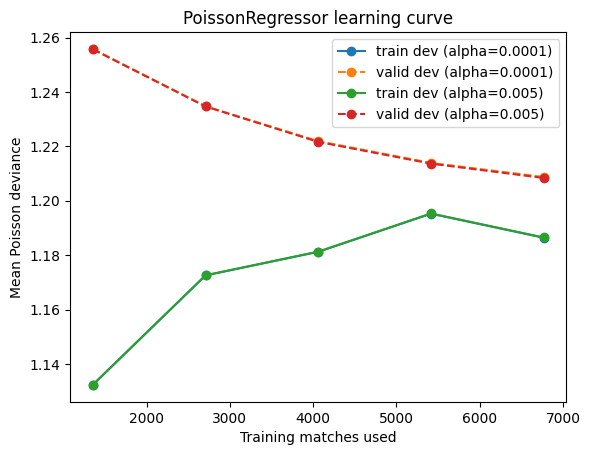

In [9]:

def eval_poisson(model, df, y_col, feature_cols):
    X = df[feature_cols].to_numpy()
    y_true = df[y_col].to_numpy(dtype=float)
    y_pred = np.clip(model.predict(X), 1e-9, None)

    return {
        "poisson_deviance": mean_poisson_deviance(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "y_pred": y_pred
    }

def learning_curve_poisson(team_df, y_col, feature_cols,
                           alphas=(0.001,), train_sizes=(0.2,0.4,0.6,0.8,1.0),
                           time_order_col="Date"):
    df = team_df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    train_end_date="2019-05-31"
    valid_start_date="2019-08-01"

    df = df.dropna(subset=feature_cols + ["goals_for"])

    df = add_time_decay_weights(df, date_col="Date", half_life_years=1.5)


    if train_end_date is not None and valid_start_date is not None:
        train_end_date = pd.to_datetime(train_end_date)
        valid_start_date = pd.to_datetime(valid_start_date)

        train_df = df[df["Date"] <= train_end_date]
        valid_df = df[df["Date"] >= valid_start_date]
    else:
        train_df = df
        valid_df = None

    dtr = train_df.copy()
    dva = valid_df.copy()
    dtr[time_order_col] = pd.to_datetime(dtr[time_order_col])
    dva[time_order_col] = pd.to_datetime(dva[time_order_col])

    dtr = dtr.sort_values(time_order_col).reset_index(drop=True)

    X_va = dva[feature_cols].to_numpy()
    y_va = dva[y_col].to_numpy(dtype=float)

    plt.figure()

    for alpha in alphas:
        train_devs = []
        valid_devs = []
        ns = []

        for frac in train_sizes:
            n = max(50, int(len(dtr) * frac))
            sub = dtr.iloc[:n].dropna(subset=feature_cols + [y_col])

            X_tr = sub[feature_cols].to_numpy()
            y_tr = sub[y_col].to_numpy(dtype=float)

            model = PoissonRegressor(alpha=alpha, max_iter=3000)
            model.fit(X_tr, y_tr)

            yhat_tr = np.clip(model.predict(X_tr), 1e-9, None)
            yhat_va = np.clip(model.predict(X_va), 1e-9, None)

            train_devs.append(mean_poisson_deviance(y_tr, yhat_tr))
            valid_devs.append(mean_poisson_deviance(y_va, yhat_va))
            ns.append(n)

        plt.plot(ns, train_devs, marker="o", label=f"train dev (alpha={alpha})")
        plt.plot(ns, valid_devs, marker="o", linestyle="--", label=f"valid dev (alpha={alpha})")

    plt.xlabel("Training matches used")
    plt.ylabel("Mean Poisson deviance")
    plt.title("PoissonRegressor learning curve")
    plt.legend()
    plt.show()

learning_curve_poisson(
    team_df = team_df,
    y_col="goals_for",
    feature_cols=feature_cols,
    alphas=(0.0001,0.005),
    train_sizes=(0.2,0.4,0.6,0.8,1.0)
)

Validation deviance consistently decreases as data
increases

This is the single most important takeaway.

*   Validation deviance starts high (~1.23)
*   Falls steadily as more data is added
*   Ends around ~1.19


Interpretation

The model is:


*   learning real signal
*   generalising better with more data
*   not just memorising noise




Training deviance increases slightly with more data:
Early on:

*   With very little data, the model can overfit → artificially low training deviance

As you add more matches:


*   The data becomes more diverse
*   The model is forced to compromise
*   Training deviance increases slightly

Training and validation curves converge:

*   By ~5,500 - 7,000 matches: Training deviance is approximately equal to variation deviance
*   This means that the feature set is about as expressive as this model class allows

It plateaus around ~1.18 – 1.19






In [10]:

def add_time_decay_weights_matchlevel(df, date_col="Date", half_life_years=1.5):
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    max_date = out[date_col].max()
    age_years = (max_date - out[date_col]).dt.days / 365.25
    out["sample_weight"] = 0.5 ** (age_years / half_life_years)
    return out

def train_poisson_match_models_with_decay(
    home_goal_df,
    away_goal_df,
    home_feature_cols=None,
    away_feature_cols=None,
    date_col="Date",
    half_life_years=1.5,
    alpha=0.001
):

    if home_feature_cols is None:
        home_feature_cols = ["home_adv", "home_attack", "away_def_weak", "home_vs_away_def"]

    if away_feature_cols is None:
        away_feature_cols = ["away_attack", "home_def_weak", "away_vs_home_def"]

    home_w = add_time_decay_weights_matchlevel(home_goal_df, date_col=date_col, half_life_years=half_life_years)
    away_w = add_time_decay_weights_matchlevel(away_goal_df, date_col=date_col, half_life_years=half_life_years)

    home_w = home_w.dropna(subset=home_feature_cols + ["FTHG", "sample_weight"])
    away_w = away_w.dropna(subset=away_feature_cols + ["FTAG", "sample_weight"])

    Xh = home_w[home_feature_cols].to_numpy()
    yh = home_w["FTHG"].to_numpy()
    wh = home_w["sample_weight"].to_numpy()

    home_model = PoissonRegressor(alpha=alpha, max_iter=3000)
    home_model.fit(Xh, yh, sample_weight=wh)

    Xa = away_w[away_feature_cols].to_numpy()
    ya = away_w["FTAG"].to_numpy()
    wa = away_w["sample_weight"].to_numpy()

    away_model = PoissonRegressor(alpha=alpha, max_iter=3000)
    away_model.fit(Xa, ya, sample_weight=wa)

    return {
        "home_model": home_model,
        "away_model": away_model,
        "home_feature_cols": home_feature_cols,
        "away_feature_cols": away_feature_cols,
        "half_life_years": half_life_years,
        "alpha": alpha
    }
models2 = train_poisson_match_models_with_decay(
    home_goal_df,
    away_goal_df,
    half_life_years=1.5,   # try 1.5–4.0
    alpha=0.001
)

print(list(models2))


['home_model', 'away_model', 'home_feature_cols', 'away_feature_cols', 'half_life_years', 'alpha']


In [11]:
def train_stat_match_models_with_decay(
    home_stat_df,
    away_stat_df,
    stat_name: str,
    home_feature_cols,
    away_feature_cols,
    home_target_col=None,
    away_target_col=None,
    date_col="Date",
    half_life_years=1.5,
    alpha=0.001
):
    if home_target_col is None:
        home_target_col = f"{stat_name}_home"
    if away_target_col is None:
        away_target_col = f"{stat_name}_away"
    home_w = add_time_decay_weights_matchlevel(home_stat_df, date_col=date_col, half_life_years=half_life_years)
    away_w = add_time_decay_weights_matchlevel(away_stat_df, date_col=date_col, half_life_years=half_life_years)

    home_w = home_w.dropna(subset=home_feature_cols + [home_target_col, "sample_weight"])
    away_w = away_w.dropna(subset=away_feature_cols + [away_target_col, "sample_weight"])
    Xh = home_w[home_feature_cols].to_numpy()
    yh = home_w[home_target_col].to_numpy()
    wh = home_w["sample_weight"].to_numpy()

    home_model = PoissonRegressor(alpha=alpha, max_iter=3000)
    home_model.fit(Xh, yh, sample_weight=wh)

    Xa = away_w[away_feature_cols].to_numpy()
    ya = away_w[away_target_col].to_numpy()
    wa = away_w["sample_weight"].to_numpy()

    away_model = PoissonRegressor(alpha=alpha, max_iter=3000)
    away_model.fit(Xa, ya, sample_weight=wa)
    return {
        "stat": stat_name,
        "home_model": home_model,
        "away_model": away_model,
        "home_feature_cols": home_feature_cols,
        "away_feature_cols": away_feature_cols,
        "home_target_col": home_target_col,
        "away_target_col": away_target_col,
        "half_life_years": half_life_years,
        "alpha": alpha
    }

def train_all_stats(
    team_df_strength,
    stats=("corners", "yellows", "reds","shots","sot"),
    date_col="Date",
    half_life_years=1.5,
    alpha=0.001
):
    stat_models = {}
    for stat in stats:
        home_df, away_df, home_feats, away_feats = build_match_level_df_for_stat(team_df_strength, stat)

        stat_models[stat] = train_stat_match_models_with_decay(
            home_stat_df=home_df,
            away_stat_df=away_df,
            stat_name=stat,
            home_feature_cols=home_feats,
            away_feature_cols=away_feats,
            date_col=date_col,
            half_life_years=half_life_years,
            alpha=alpha
        )


    return stat_models
stat_models = train_all_stats(
    team_df,
    stats=("corners","reds","yellows","shots","sot"),
    half_life_years=1.5,
    alpha=0.001
)



In [12]:

def _latest_strength_snapshot(team_df, team, as_of_date):

    as_of_date = pd.to_datetime(as_of_date)

    sub = team_df[
        (team_df["team"] == team) &
        (team_df["Date"] < as_of_date)
    ].sort_values("Date")

    if sub.empty:
        raise ValueError(
            f"No history found for team={team} before {as_of_date.date()}."
        )

    return sub.iloc[-1]


def build_match_features_for_fixture(team_df, home_team, away_team, match_date):

    h = _latest_strength_snapshot(team_df, home_team, match_date)
    a = _latest_strength_snapshot(team_df, away_team, match_date)

    home_attack = h["attack_strength_ewm"]
    home_def_weak = h["defense_weakness_ewm"]

    away_attack = a["attack_strength_ewm"]
    away_def_weak = a["defense_weakness_ewm"]

    X_home = pd.DataFrame([{
        "home_adv": 1,
        "home_attack": home_attack,
        "away_def_weak": away_def_weak,
        "home_vs_away_def": home_attack - away_def_weak
    }])

    X_away = pd.DataFrame([{
        "away_attack": away_attack,
        "home_def_weak": home_def_weak,
        "away_vs_home_def": away_attack - home_def_weak
    }])

    return X_home, X_away


def predict_expected_goals_matchlevel(models2, team_df, home_team, away_team, match_date):

    X_home, X_away = build_match_features_for_fixture(team_df, home_team, away_team, match_date)

    X_home = X_home[models2["home_feature_cols"]]
    X_away = X_away[models2["away_feature_cols"]]

    lam_h = float(models2["home_model"].predict(X_home.to_numpy())[0])
    lam_a = float(models2["away_model"].predict(X_away.to_numpy())[0])

    lam_h = max(lam_h, 1e-6)
    lam_a = max(lam_a, 1e-6)

    return lam_h, lam_a

def round_half_up(x, nDigits=0):
    q = Decimal(10) ** -nDigits
    return float(Decimal(str(x)).quantize(q, rounding=ROUND_HALF_UP))

def predict_stats_for_fixture(team_df, stat_models, home_team, away_team, match_date, stats=("corners","yellows","reds","shots","sot")):

    h = _latest_strength_snapshot(team_df, home_team, match_date)
    a = _latest_strength_snapshot(team_df, away_team, match_date)

    preds = {}

    for stat in stats:
        home_row = {
            "home_adv": 1,
            f"{stat}_home_for": h[f"{stat}_for_ewm"],
            f"{stat}_away_concede": a[f"{stat}_against_ewm"],
            f"{stat}_home_vs_away": h[f"{stat}_for_ewm"] - a[f"{stat}_against_ewm"],
        }

        away_row = {
            f"{stat}_away_for": a[f"{stat}_for_ewm"],
            f"{stat}_home_concede": h[f"{stat}_against_ewm"],
            f"{stat}_away_vs_home": a[f"{stat}_for_ewm"] - h[f"{stat}_against_ewm"],
        }

        X_home = pd.DataFrame([home_row])[stat_models[stat]["home_feature_cols"]]
        X_away = pd.DataFrame([away_row])[stat_models[stat]["away_feature_cols"]]

        lam_home = float(stat_models[stat]["home_model"].predict(X_home.to_numpy())[0])
        lam_away = float(stat_models[stat]["away_model"].predict(X_away.to_numpy())[0])

        preds[stat] = {
            "home_expected": max(lam_home, 1e-6),
            "away_expected": max(lam_away, 1e-6),
        }

    return preds

In [13]:

def lambda_to_match_probs(lambda_home, lambda_away, max_goals=13):

    goals = np.arange(0, max_goals + 1)

    home_goal_probs = poisson.pmf(goals, lambda_home)
    away_goal_probs = poisson.pmf(goals, lambda_away)

    score_matrix = np.outer(home_goal_probs, away_goal_probs)

    p_home = np.tril(score_matrix, -1).sum()
    p_draw = np.trace(score_matrix)
    p_away = np.triu(score_matrix, 1).sum()

    i, j = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
    most_likely_score = str(i) + "-" + str(j)
    p_home_0 = home_goal_probs[0]
    p_away_0 = away_goal_probs[0]

    return {
        "P_home": str(round(p_home * 100,3)) + "%",
        "P_draw": str(round(p_draw * 100,3)) + "%",
        "P_away": str(round(p_away * 100,3)) + "%",
        "most_likely_score": most_likely_score,
        "score_matrix": score_matrix,
        "P_home_0_goals": str(round(p_home_0 * 100,3)) + "%",
        "P_away_0_goals": str(round(p_away_0 * 100,3)) + "%"
    }


In [14]:

base = "https://fantasy.premierleague.com/api/"
bootstrap = requests.get(base + "bootstrap-static/").json()

players = pd.DataFrame(bootstrap["elements"])
teams   = pd.DataFrame(bootstrap["teams"])
teamName = dict(zip(teams["id"], teams["name"]))
teamID = dict(zip(teams["name"], teams["id"]))
print(list(teamID.keys()))
players["team_name"] = players["team"].map(teamName)
num_cols = [
    "minutes", "goals_scored", "assists", "yellow_cards", "red_cards",
    "expected_goals", "expected_assists",
    "expected_goals_per_90", "expected_assists_per_90",
    "starts_per_90",
    "chance_of_playing_next_round", "chance_of_playing_this_round",
]
for c in num_cols:
    if c in players.columns:
        players[c] = pd.to_numeric(players[c], errors="coerce")
players_playable = players.copy()
players_playable["chance_of_playing_next_round"] = players_playable["chance_of_playing_next_round"].fillna(100)

def expected_minutes(row) -> float:
    sp90 = row.get("starts_per_90", 0.0)
    if pd.isna(sp90):
        sp90 = 0.0
    p_start = float(np.clip(sp90, 0, 1))

    chance = row.get("chance_of_playing_next_round", 100.0)
    if pd.isna(chance):
        chance = 100.0
    chance_mult = float(np.clip(chance / 100.0, 0, 1))

    return 90.0 * p_start * chance_mult

def rank_players_for_fixture(
    players_df: pd.DataFrame,
    team_id: int,
    team_lambda_goals: float,
    team_expected_yellows: float,
    team_expected_shots: float,
    team_expected_sot: float,
    topn=3,
):

    df = players_df[players_df["team"] == team_id].copy()

    df["exp_mins"] = df.apply(expected_minutes, axis=1)

    df["xg90"] = pd.to_numeric(df.get("expected_goals_per_90", 0), errors="coerce").fillna(0.0)
    df["xa90"] = pd.to_numeric(df.get("expected_assists_per_90", 0), errors="coerce").fillna(0.0)

    df["threat"] = pd.to_numeric(df.get("threat", 0), errors="coerce").fillna(0.0)

    df["xg_match"] = df["xg90"] * (df["exp_mins"] / 90.0)
    df["xa_match"] = df["xa90"] * (df["exp_mins"] / 90.0)

    df["mins"] = pd.to_numeric(df.get("minutes", 0), errors="coerce").fillna(0.0)
    df["yc"] = pd.to_numeric(df.get("yellow_cards", 0), errors="coerce").fillna(0.0)
    df["yc_per90"] = np.where(df["mins"] > 0, df["yc"] / (df["mins"] / 90.0), 0.0)
    df["yc_match_rate"] = df["yc_per90"] * (df["exp_mins"] / 90.0)

    sum_xg = df["xg_match"].sum()
    sum_xa = df["xa_match"].sum()
    sum_yc = df["yc_match_rate"].sum()

    df["E_goals_player"] = team_lambda_goals * (df["xg_match"] / sum_xg) if sum_xg > 0 else 0.0
    df["E_assists_player"] = team_lambda_goals * (df["xa_match"] / sum_xa) if sum_xa > 0 else 0.0
    df["E_yellows_player"] = team_expected_yellows * (df["yc_match_rate"] / sum_yc) if sum_yc > 0 else 0.0

    df["P_score_1plus"]  = 1 - np.exp(-df["E_goals_player"])
    df["P_assist_1plus"] = 1 - np.exp(-df["E_assists_player"])
    df["P_yellow"]       = 1 - np.exp(-df["E_yellows_player"])

    df["shots_w"] = df["threat"] * (df["exp_mins"] / 90.0)
    sum_shots_w = df["shots_w"].sum()
    df["E_shots_player"] = team_expected_shots * (df["shots_w"] / sum_shots_w) if sum_shots_w > 0 else 0.0

    df["sot_w"] = df["xg90"] * (df["exp_mins"] / 90.0)
    sum_sot_w = df["sot_w"].sum()
    df["E_sot_player"] = team_expected_sot * (df["sot_w"] / sum_sot_w) if sum_sot_w > 0 else 0.0

    df["P_shot_1plus"] = 1 - np.exp(-df["E_shots_player"])
    df["P_sot_1plus"]  = 1 - np.exp(-df["E_sot_player"])

    keep = [
        "web_name", "team_name", "element_type",
        "exp_mins",
        "P_score_1plus", "E_goals_player",
        "P_assist_1plus", "E_assists_player",
        "P_yellow", "E_yellows_player",
        "E_shots_player", "P_shot_1plus",
        "E_sot_player", "P_sot_1plus",
        "xg90", "xa90", "threat", "yc_per90",
        "starts_per_90", "chance_of_playing_next_round"
    ]

    top_scorers  = df.sort_values("P_score_1plus", ascending=False)[keep].head(topn)
    top_assists  = df.sort_values("P_assist_1plus", ascending=False)[keep].head(topn)
    top_yellows  = df.sort_values("P_yellow", ascending=False)[keep].head(topn)
    top_shooters = df.sort_values("E_shots_player", ascending=False)[keep].head(topn)
    top_sot      = df.sort_values("E_sot_player", ascending=False)[keep].head(topn)

    return top_scorers, top_assists, top_yellows, top_shooters, top_sot



def top3_across_both_teams(
    players_df: pd.DataFrame,
    team_name_to_id: dict,
    home_team_name: str, away_team_name: str,
    lam_home: float, lam_away: float,
    y_home: float, y_away: float,
    shots_home: float, shots_away: float,
    sot_home: float, sot_away: float,
    topn=3,
    team_alias=None
):
    if team_alias is None:
        team_alias = {}

    home_name_fpl = team_alias.get(home_team_name, home_team_name)
    away_name_fpl = team_alias.get(away_team_name, away_team_name)

    if home_name_fpl not in team_name_to_id:
        raise KeyError(f"Home team '{home_name_fpl}' not in FPL teams (check alias/spelling).")
    if away_name_fpl not in team_name_to_id:
        raise KeyError(f"Away team '{away_name_fpl}' not in FPL teams (check alias/spelling).")

    home_id = team_name_to_id[home_name_fpl]
    away_id = team_name_to_id[away_name_fpl]

    hs, ha, hy, hshots, hsot = rank_players_for_fixture(
        players_df, home_id, lam_home, y_home, shots_home, sot_home, topn=25
    )
    as_, aa, ay, ashots, asot = rank_players_for_fixture(
        players_df, away_id, lam_away, y_away, shots_away, sot_away, topn=25
    )

    scorers   = pd.concat([hs.assign(side="home"), as_.assign(side="away")]).sort_values("P_score_1plus", ascending=False).head(topn)
    assisters = pd.concat([ha.assign(side="home"), aa.assign(side="away")]).sort_values("P_assist_1plus", ascending=False).head(topn)
    yellows   = pd.concat([hy.assign(side="home"), ay.assign(side="away")]).sort_values("P_yellow", ascending=False).head(topn)

    shooters  = pd.concat([hshots.assign(side="home"), ashots.assign(side="away")]).sort_values("E_shots_player", ascending=False).head(topn)
    sotters   = pd.concat([hsot.assign(side="home"), asot.assign(side="away")]).sort_values("E_sot_player", ascending=False).head(topn)

    return scorers, assisters, yellows, shooters, sotters

#spurs and man utd - fpl
#tottenham and man united - footballdata.org


['Arsenal', 'Aston Villa', 'Burnley', 'Bournemouth', 'Brentford', 'Brighton', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Leeds', 'Liverpool', 'Man City', 'Man Utd', 'Newcastle', "Nott'm Forest", 'Sunderland', 'Spurs', 'West Ham', 'Wolves']


In [15]:

for idx,(home_team,away_team,match_date) in enumerate(zip(homeTeamsToPredict,awayTeamsToPredict,datesToPredict)):
#home_team = "Man City"
#away_team = "Sunderland"
#match_date = "2026-04-01"
  stat_preds = predict_stats_for_fixture(team_df, stat_models, home_team, away_team, match_date)
  team_change = {
    "Tottenham": "Spurs",
    "Man United": "Man Utd",
}
  fpl_home_team = home_team
  fpl_away_team = away_team
  if fpl_home_team in team_change.keys():
    fpl_home_team = team_change[fpl_home_team]
  if fpl_away_team in team_change.keys():
    fpl_away_team = team_change[fpl_away_team]
  #print(fpl_home_team,fpl_away_team)
  lam_h, lam_a = predict_expected_goals_matchlevel(models2, team_df, home_team, away_team, match_date)
  dec_h, dec_a = round_half_up(lam_h),round_half_up(lam_a)
  '''
  top_scorers, top_assisters, top_yellows, top_shots, top_sot = top3_across_both_teams(
    players_df=players_playable,
    team_name_to_id = teamID,
    home_team_name=fpl_home_team,
    away_team_name=fpl_away_team,
    lam_home=lam_h,
    lam_away=lam_a,
    y_home=stat_preds["yellows"]["home_expected"],
    y_away=stat_preds["yellows"]["away_expected"],
    shots_home = stat_preds["shots"]["home_expected"],
    shots_away = stat_preds["shots"]["away_expected"],
    sot_home = stat_preds["sot"]["home_expected"],
    sot_away = stat_preds["sot"]["away_expected"],
    topn=3,
    team_alias=None
)'''
  print(f"{home_team} vs {away_team} on {match_date}")

  probs = lambda_to_match_probs(lam_h, lam_a)
  print(f"Home win: " +  probs['P_home'])
  print(f"Draw: " + probs['P_draw'])
  print(f"Away win: " + probs['P_away'])
  print(f"Home Clean Sheet: " + probs["P_away_0_goals"])
  print(f"Away Clean Sheet: " + probs["P_home_0_goals"])
  print("Most likely score (Historical):", probs["most_likely_score"])
  print("Expected goals:")
  print("  Home (λ_home):", round(lam_h, 3))
  print("  Away (λ_away):", round(lam_a, 3))
  print("Expected Score (xG): " + str(int(dec_h)) + "-" + str(int(dec_a)))
  for pred in stat_preds:
    if pred=="sot":
      print("Predicted " + "shots on target" + ": ")
    else:
      print("Predicted " + pred + ": ")
    h,a = (stat_preds[pred]["home_expected"]),(stat_preds[pred]["away_expected"])
    h,a = round_half_up(h),round_half_up(a)
    print("Home: " + str(int(h)))
    print("Away: " + str(int(a)))
  '''
  print("Top 3 likely scorers:")
  print(top_scorers[["web_name","team_name","P_score_1plus","xg90"]])

  print("\nTop 3 likely assisters:")
  print(top_assisters[["web_name","team_name","P_assist_1plus","xa90"]])

  print("\nTop 3 most likely to get a yellow:")
  print(top_yellows[["web_name","team_name","P_yellow","yc_per90","exp_mins"]])
  print("\nTop 3 shots:\n", top_shots[["web_name","team_name","E_shots_player","P_shot_1plus","threat"]])
  print("\nTop 3 shots on target:\n", top_sot[["web_name","team_name","E_sot_player","P_sot_1plus","xg90"]])
        '''
  print("--------------------------------------------------------------")

Brentford vs Arsenal on 2027-01-10
Home win: 21.397%
Draw: 20.796%
Away win: 57.807%
Home Clean Sheet: 12.274%
Away Clean Sheet: 29.891%
Most likely score (Historical): 1-2
Expected goals:
  Home (λ_home): 1.208
  Away (λ_away): 2.098
Expected Score (xG): 1-2
Predicted corners: 
Home: 4
Away: 5
Predicted yellows: 
Home: 2
Away: 2
Predicted reds: 
Home: 0
Away: 0
Predicted shots: 
Home: 10
Away: 16
Predicted shots on target: 
Home: 4
Away: 5
--------------------------------------------------------------


In [16]:


newSeasons = ['2425','2526']
all_seasons_two = []
for season in newSeasons:
    try:
        url = base_url.format(season)
        df = pd.read_csv(url)
        df['Season'] = season
        all_seasons_two.append(df)

    except Exception as e:
        print(f"Failed {season}: {e}")

newPremData = pd.concat(all_seasons_two, ignore_index=True)

print(f"\nTotal matches: {len(newPremData)}")

columns_to_keep = [
    'Date', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',
    'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HY','AY','HR','AR',
    'B365H', 'B365D', 'B365A', 'Season'
]
newCleanData = newPremData[columns_to_keep]
devHome, devAway = [],[]
yTrueHome,yPredHome = [],[]
yTrueAway,yPredAway = [],[]
dates = []
for observation in newCleanData.itertuples():
  homeTeam,awayTeam = observation[2],observation[3]
  if homeTeam=="Ipswich" or awayTeam=="Ipswich": #no training data for ipswich so it would be considered an anomaly
    continue
  date = ""
  date+=(observation[1][6:10])+"-"+(observation[1][3:5])+"-"+observation[1][0:2]
  lam_h, lam_a = predict_expected_goals_matchlevel(models2, team_df, homeTeam, awayTeam, date)
  actual_h,actual_a = observation[4],observation[5]
  yTrueHome.append(actual_h)
  yPredHome.append(lam_h)
  yTrueAway.append(actual_a)
  yPredAway.append(lam_a)
  dates.append(date)
yTrueHome = np.asarray(yTrueHome)
yPredHome = np.clip(np.asarray(yPredHome), 1e-9, None)
yTrueAway = np.asarray(yTrueAway)
yPredAway = np.clip(np.asarray(yPredAway), 1e-9, None)
devHome = np.where(
        yTrueHome > 0,
        2 * (yTrueHome * np.log(yTrueHome / yPredHome) - (yTrueHome - yPredHome)),
        2 * yPredHome
    )
devAway = np.where(
        yTrueAway > 0,
        2 * (yTrueAway * np.log(yTrueAway / yPredAway) - (yTrueAway - yPredAway)),
        2 * yPredAway
    )



Total matches: 590


/tmp/ipython-input-168460658.py:47: RuntimeWarning: divide by zero encountered in log
  2 * (yTrueHome * np.log(yTrueHome / yPredHome) - (yTrueHome - yPredHome)),
/tmp/ipython-input-168460658.py:47: RuntimeWarning: invalid value encountered in multiply
  2 * (yTrueHome * np.log(yTrueHome / yPredHome) - (yTrueHome - yPredHome)),
/tmp/ipython-input-168460658.py:52: RuntimeWarning: divide by zero encountered in log
  2 * (yTrueAway * np.log(yTrueAway / yPredAway) - (yTrueAway - yPredAway)),
/tmp/ipython-input-168460658.py:52: RuntimeWarning: invalid value encountered in multiply
  2 * (yTrueAway * np.log(yTrueAway / yPredAway) - (yTrueAway - yPredAway)),


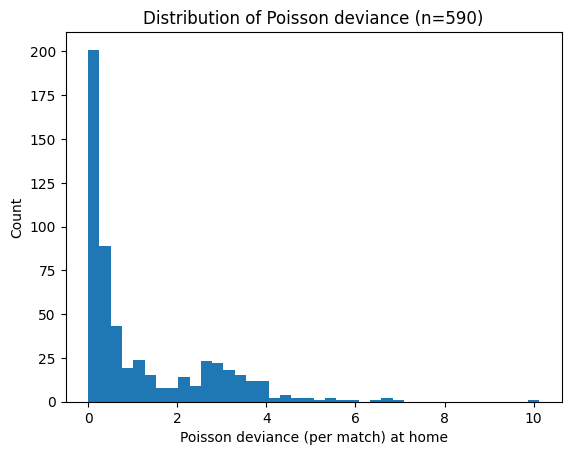

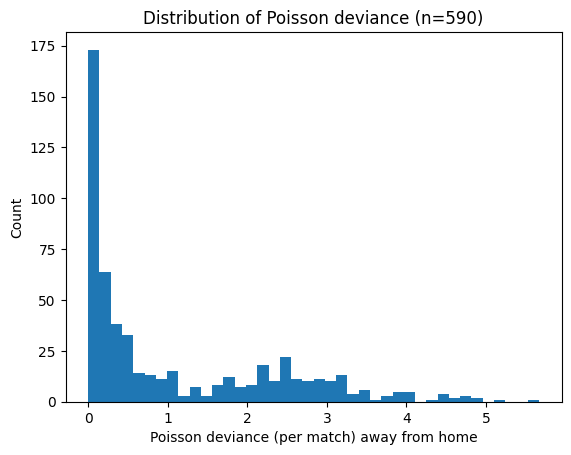

In [17]:

plt.figure()
plt.hist(devHome, bins=40)
plt.xlabel("Poisson deviance (per match) at home")
plt.ylabel("Count")
plt.title("Distribution of Poisson deviance (n=590)")
plt.show()

plt.figure()
plt.hist(devAway, bins=40)
plt.xlabel("Poisson deviance (per match) away from home")
plt.ylabel("Count")
plt.title("Distribution of Poisson deviance (n=590)")
plt.show()



1.   Big spike near 0 (left side)

For many matches, predicted λ was very close to the actual goals

2.   Long right tail (towards 5–10)

These are matches where the model was badly wrong

Low-scoring, high-variance sport → rare but unavoidable shocks.

The fact that: most mass is < ~2 and only a few matches are > ~6–8 is a healthy distribution.





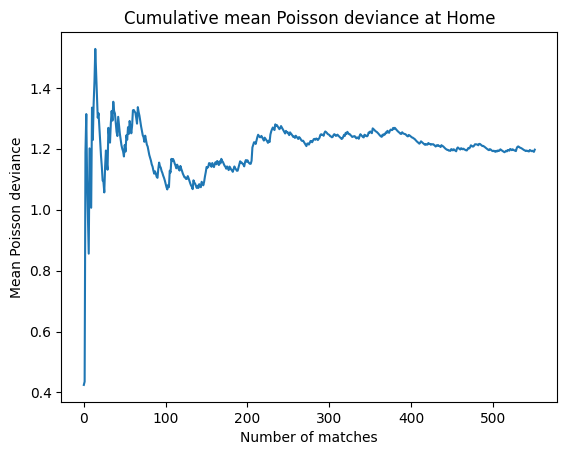

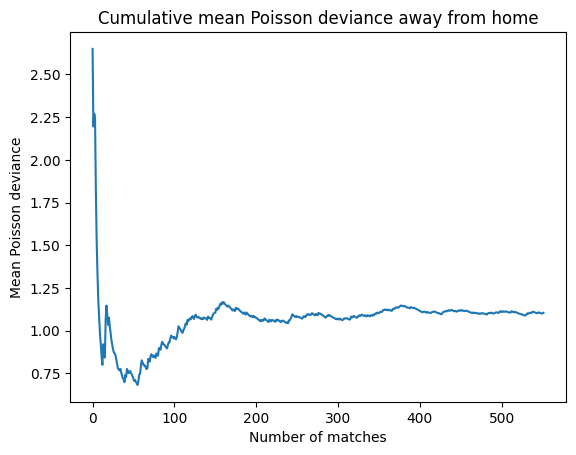

In [18]:
cum_mean_dev_home = np.cumsum(devHome) / np.arange(1, len(devHome) + 1)

plt.figure()
plt.plot(cum_mean_dev_home)
plt.xlabel("Number of matches")
plt.ylabel("Mean Poisson deviance")
plt.title("Cumulative mean Poisson deviance at Home")
plt.show()

cum_mean_dev_away = np.cumsum(devAway) / np.arange(1, len(devAway) + 1)

plt.figure()
plt.plot(cum_mean_dev_away)
plt.xlabel("Number of matches")
plt.ylabel("Mean Poisson deviance")
plt.title("Cumulative mean Poisson deviance away from home")
plt.show()



1.   Wild swings early on

At the start: very few matches

one weird result massively affects the average


2.   Stabilisation after ~100 – 150 matches (around 1.15 to 1.2)

Model’s behaviour is stable

Performance isn’t drifting wildly over time

No obvious regime break


3. Away goal Prediction is slightly easier than home:

Away goals have lower variance

Fewer Tactical extremes










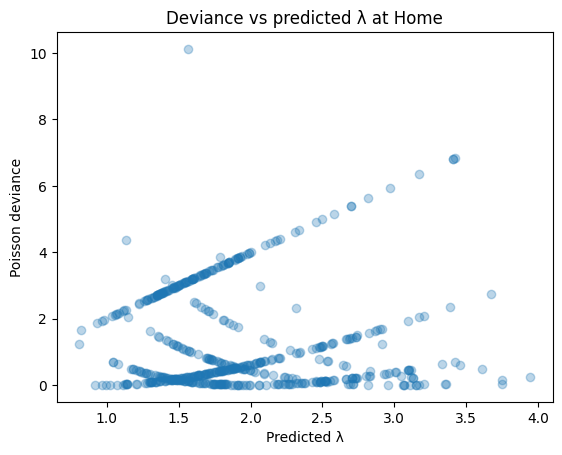

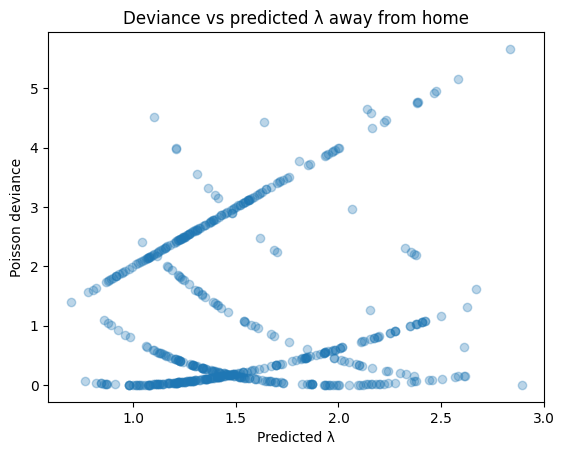

In [19]:
plt.figure()
plt.scatter(yPredHome, devHome, alpha=0.3)
plt.xlabel("Predicted λ")
plt.ylabel("Poisson deviance")
plt.title("Deviance vs predicted λ at Home")
plt.show()

plt.figure()
plt.scatter(yPredAway, devAway, alpha=0.3)
plt.xlabel("Predicted λ")
plt.ylabel("Poisson deviance")
plt.title("Deviance vs predicted λ away from home")
plt.show()